# Brute force algorithm

naive implementation using DTW and TWED distances as a control case for future implementations.

Here we will compute distance matrix for a given dataset and save the result to disk. Then, using this matrix we will evaluate performance on 1-nearest neighbor classification and Average Mean Presicion at K (AP@K)

In [128]:
import pandas as pd
import numpy as np
from collections import defaultdict
from sklearn.model_selection import train_test_split
from scipy.spatial import distance
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
import multiprocessing as mp
import os
import matplotlib.pyplot as plt
%matplotlib inline

## Dataset generation

first we create a small dataset used for testing on which we reduce the number of classes

In [79]:
def load_pandas(path,  **kwargs):
    data_filename = kwargs.pop("data_filename")
    meta_filename = kwargs.pop("meta_filename")
    df = pd.read_csv(path + data_filename)
    df_metadata = pd.read_csv(path + meta_filename)

    passband_id = 3

    df = df[df["passband"] == passband_id]
    df = df.sort_values(by=["object_id", "mjd"])
    df_metadata = df_metadata.sort_values(by=["object_id"])
    df = df.groupby("object_id")
    fluxes = df['flux'].apply(list)
    times = df['mjd'].apply(list)
    ids = df.groups.keys()
    dataset = [np.array(fluxes.loc[i]) for i in ids]
    times_arr = []
    for i in ids:
        times_i = np.array(times.loc[i])
        times_i = times_i - times_i[0]
        times_arr.append(times_i)

    labels = df_metadata["target"].to_numpy()

    return dataset, times_arr, labels, len(dataset)

def adjust_labels(labels):
    classes = np.sort(np.unique(labels))
    classes_count = np.zeros(len(classes), dtype=int)
    label_index = np.zeros(m)
    for i, l in enumerate(labels):
        position = np.where(classes == l)[0][0]
        classes_count[position] += 1
        label_index[i] = position

    count_sort_best_index = np.argsort(classes_count)[::-1]
    
    return classes_count, classes, label_index, count_sort_best_index

path = "/home/frmunoz/Documents/tesis/data/"
dataset, times, labels, m = load_pandas(path, data_filename="training_set.csv.zip", meta_filename="training_set_metadata.csv")
class_count, lclasses, label_index, sort_class_count_index = adjust_labels(labels)

print("full PLaSTiCC dataset size: ", m)
print("number of classes/targets: ", np.unique(labels).size)
print("classes count:")
for i in sort_class_count_index:
    print(">> class: ", lclasses[i], ", count: ", class_count[i])

full PLaSTiCC dataset size:  7848
number of classes/targets:  14
classes count:
>> class:  90 , count:  2313
>> class:  42 , count:  1193
>> class:  65 , count:  981
>> class:  16 , count:  924
>> class:  15 , count:  495
>> class:  62 , count:  484
>> class:  88 , count:  370
>> class:  92 , count:  239
>> class:  67 , count:  208
>> class:  52 , count:  183
>> class:  95 , count:  175
>> class:  6 , count:  151
>> class:  64 , count:  102
>> class:  53 , count:  30


In [82]:
def get_small_dataset(dataset, times, labels, sort_class_count_index, classes, m, n1, n2, c):
    # n: size of the small dataset
    # c: use the 'c' classes most present in the original dataset
    
    classes_cut = []
    for i in sort_class_count_index[:c]:
        classes_cut.append(classes[i])
    
    data_time_tuple = []
    labels_cut = []
    for t, y, l in zip(times, dataset, labels):
        if l in classes_cut:
            data_time_tuple.append((t, y))
            labels_cut.append(l)
    
    x_train, x_test, y_train, y_test = train_test_split(data_time_tuple, labels_cut,
                                                    test_size=len(labels_cut) - n1,
                                                    random_state=0,
                                                    stratify=labels_cut)
    
    dataset_split = []
    times_split = []
    for d_tuple in x_train:
        times_split.append(d_tuple[0])
        dataset_split.append(d_tuple[1])
            
    
    if n2 < len(y_test) - 1:
        
        _, x_test, _, y_test = train_test_split(x_test, y_test,
                                            test_size=n2,
                                            random_state=0,
                                            stratify=y_test)
        
    d_test_split = []
    t_test_split = []
    for d_tuple in x_test:
        d_test_split.append(d_tuple[1])
        t_test_split.append(d_tuple[0])
    
    return dataset_split, times_split, y_train, d_test_split, t_test_split, y_test

In [83]:
n1_arr = [10, 100, 200, 500, 1000, 1000, 1000, 2000, 2000, 5000,  int(m * 0.8)]
n2_arr = [10, 100, 100, 500, 500, 1000, 1000, 1000, 2000, 2847, m - int(m * 0.8)]
c_arr = [2, 4, 4, 4, 4, 4, 10, len(lclasses), len(lclasses), len(lclasses), len(lclasses)]


datasets_folder = "/home/frmunoz/Documents/tesis/data/plasticc_sub_dataset/"
train_d_smalls = []
train_t_smalls = []
train_l_smalls = []
test_d_smalls = []
test_t_smalls = []
test_l_smalls = []

for c, n1, n2 in zip(c_arr, n1_arr, n2_arr):
    D_s1, t_s1, l_s1, D_s1_test, t_s1_test, l_s1_test = get_small_dataset(dataset, times, labels, 
                                                                          sort_class_count_index, lclasses,
                                                                          m, n1, n2, c)
    train_d_smalls.append(D_s1)
    train_t_smalls.append(t_s1)
    train_l_smalls.append(l_s1)
    test_d_smalls.append(D_s1_test)
    test_t_smalls.append(t_s1_test)
    test_l_smalls.append(l_s1_test)
    
    # save to disk
    skip = False
    for type_i, data_i in zip(["d", "t", "l"],
                             [(D_s1, D_s1, D_s1_test), (t_s1, t_s1_test), (l_s1, l_s1_test)]):
        out_file_train = datasets_folder + "train_{}_n{}_c{}.npy".format(type_i, n1, c)
        out_file_test = datasets_folder + "test_{}_n{}_c{}.npy".format(type_i, n2, c)
        if os.path.exists(out_file_train) and os.path.exists(out_file_test):
            print(">>> SKIP: dataset of size:", n1, "train,", n2, "test, with", c, "classes already exists")
            skip = True
            break
        else:
            np.save(out_file_train, data_i[0])
            np.save(out_file_test, data_i[1])
            
    if not skip:
        print(":::GEN train dataset of size:", n1, "and test dataset of size",  n2, "with", c, "classes")

>>> SKIP: dataset of size: 10 train, 10 test, with 2 classes already exists
>>> SKIP: dataset of size: 100 train, 100 test, with 4 classes already exists
>>> SKIP: dataset of size: 200 train, 100 test, with 4 classes already exists
>>> SKIP: dataset of size: 500 train, 500 test, with 4 classes already exists
>>> SKIP: dataset of size: 1000 train, 500 test, with 4 classes already exists
>>> SKIP: dataset of size: 1000 train, 1000 test, with 4 classes already exists
>>> SKIP: dataset of size: 1000 train, 1000 test, with 10 classes already exists
>>> SKIP: dataset of size: 2000 train, 1000 test, with 14 classes already exists
>>> SKIP: dataset of size: 2000 train, 2000 test, with 14 classes already exists
>>> SKIP: dataset of size: 5000 train, 2847 test, with 14 classes already exists
>>> SKIP: dataset of size: 6278 train, 1570 test, with 14 classes already exists


# DTW

compute distance matrix between test and train datasets using DTW distance from [here](https://github.com/pierre-rouanet/dtw)

**very expensive executions**

In [7]:
from dtw import dtw, accelerated_dtw

In [8]:
def distance_matrix(X_train, X_test):
    # compute distances between each time series on test set and train set
    n = len(X_train)
    m = len(X_test)
    res = np.ones((n, m)) * -1
    for i in range(n):
        for j in range(m):
            d, cost_matrix, acc_cost_matrix, path = accelerated_dtw(X_train[i], X_test[j], 'cosine')
            res[i][j] = d
    return res

def worker(X_train, X_test, i_subset, j_subset, out_q):
    try:
        n = len(X_train)
        m = len(X_test)
        rows = np.ones((n,m)) *  -1
        for i in range(n):
            for j in range(m):
                d, cost_matrix, acc_cost_matrix, path = accelerated_dtw(X_train[i], X_test[j], 'cosine')
                rows[i][j] = d
        out_q.put((i_subset, j_subset, rows))
    except:
        print("worker failed")
    finally:
        print("done")

# this code doesnt work on ipython notebooks when using windows system.
def dmatrix_multiprocessing(X_train, X_test, n_process):
    n = len(X_train)
    m = len(X_test)
    n_subset = n // n_process
    man = mp.Manager()
    result_queue = man.Queue()
    jobs = []
    for k in range(n_process):
        i_subset = k * n_subset
        j_subset = (k+1) * n_subset
        if j_subset > n:
            j_subset = n
        X_train_subset = X_train[i_subset:j_subset]
        jobs.append(mp.Process(target=worker, 
                               args=(X_train_subset, X_test, i_subset, j_subset, result_queue)))
        jobs[-1].start()
    
    for p in jobs:
        p.join()
    
    dmatrix = np.zeros((n, m))
    num_res = result_queue.size()
    while num_ress > 0:
        i_subset, j_subset, rows_subset = result_queue.get()
        dmatrix[i_subset:j_subset] = rows_subset
    
    return dmatrix

In [9]:
%%time
# dataset train size 10, test size 10, 2 classes
d_matrix_10_10_2 = distance_matrix(train_d_smalls[0], test_d_smalls[0])

CPU times: user 333 ms, sys: 650 µs, total: 334 ms
Wall time: 330 ms


In [10]:
%%time
# dataset train size 100, test size 100, 4 classes
d_matrix_100_100_4 = distance_matrix(train_d_smalls[1], test_d_smalls[1])

CPU times: user 24.6 s, sys: 52 ms, total: 24.6 s
Wall time: 24.7 s


for more big datasets, please run the multiprocessing algorithm from terminal, here we will just load them

## 1-nearest neighbor classification

having the distance matrix we will classify each time series on the test set using the training set. 

The procedure will be:

1. For each column on the distance matrix, get the clossest distance
2. Check training and test label looking for match. 
3. Final accuracy will be the number of matches divided by the total number of test samples.

In [109]:
def bruteforce_classifier(dataset_folder, dmatrix_folder, n1, n2, c, dist_type="dtw", input_dmatrix=None):
    if dist_type == "dtw":
        dmatrix = np.load(dmatrix_folder + "dmatrix_n{}_m{}_c{}.npy".format(n1, n2, c), allow_pickle=True)
    elif dist_type == "twed":
        dmatrix = np.load(dmatrix_folder + "dmatrix_n{}_m{}_c{}_twed.npy".format(n1, n2, c), allow_pickle=True)
    else:
        dmatrix = input_dmatrix
    train_labels = np.load(dataset_folder + "train_l_n{}_c{}.npy".format(n1, c), allow_pickle=True)
    test_labels = np.load(dataset_folder + "test_l_n{}_c{}.npy".format(n2, c), allow_pickle=True)
    
    n = len(train_labels)
    m = len(test_labels)
    count = 0
    for j in range(m):
        dmin = np.inf
        mink = -1
        for i in range(n):
            if dmatrix[i][j] < dmin:
                dmin = dmatrix[i][j]
                mink = i
        if test_labels[j] == train_labels[mink]:
            count += 1
    return count, count/m

In [156]:
# loading matrix
path1 = "/home/frmunoz/Documents/tesis/data/plasticc_sub_dataset/"
path2 = "/home/frmunoz/Documents/tesis/data/bruteforce_dmatrix/"
n1_arr = [10, 100, 200, 500, 1000, 1000, 1000, 2000, 2000, 5000,  int(m * 0.8)]
n2_arr = [10, 100, 100, 500, 500, 1000, 1000, 1000, 2000, 2847, m - int(m * 0.8)]
c_arr = [2, 4, 4, 4, 4, 4, 10, len(lclasses), len(lclasses), len(lclasses), len(lclasses)]

for n1, n2, c in zip(n1_arr, n2_arr, c_arr):
    count, acc = bruteforce_classifier(path1, path2, n1, n2, c, dist_type="dtw")
    print("accuracy for dataset [%d, %d, %d]:" % (n1, n2, c), acc)

accuracy for dataset [10, 10, 2]: 0.8
accuracy for dataset [100, 100, 4]: 0.31
accuracy for dataset [200, 100, 4]: 0.35
accuracy for dataset [500, 500, 4]: 0.318
accuracy for dataset [1000, 500, 4]: 0.348
accuracy for dataset [1000, 1000, 4]: 0.353
accuracy for dataset [1000, 1000, 10]: 0.245
accuracy for dataset [2000, 1000, 14]: 0.179
accuracy for dataset [2000, 2000, 14]: 0.179
accuracy for dataset [5000, 2847, 14]: 0.17661516853932585
accuracy for dataset [6278, 1570, 14]: 0.2337579617834395


## Mean Average Precision at K

In [114]:
def average_precision(target_test, targets_train, predicted_targets_idx):
    
    n_tp_total = np.sum([target_test == targets_train[i] for i in predicted_targets_idx])
    if n_tp_total == 0:
        return 0
    k = len(predicted_targets_idx)
    ap_sum = 0
    for i in range(k):
        tp_seen = 0
        if target_test == targets_train[predicted_targets_idx[i]]:
            for j in range(i+1):
                if target_test == targets_train[predicted_targets_idx[j]]:
                    tp_seen += 1
        ap_sum += tp_seen / (i+1)
    return ap_sum / n_tp_total

def m_av_p_k(dataset_folder, dmatrix_folder, n1, n2, c, k, dist_type="dtw", input_dmatrix=None):
    if dist_type == "dtw":
        dmatrix = np.load(dmatrix_folder + "dmatrix_n{}_m{}_c{}.npy".format(n1, n2, c), allow_pickle=True)
    elif dist_type == "twed":
        dmatrix = np.load(dmatrix_folder + "dmatrix_n{}_m{}_c{}_twed.npy".format(n1, n2, c), allow_pickle=True)
    else:
        dmatrix = input_dmatrix
    train_labels = np.load(dataset_folder + "train_l_n{}_c{}.npy".format(n1, c), allow_pickle=True)
    test_labels = np.load(dataset_folder + "test_l_n{}_c{}.npy".format(n2, c), allow_pickle=True)
    
    n = len(train_labels)
    m = len(test_labels)
    mapk = []
    for j in range(m):
        best_idx_sort = np.argsort(dmatrix[:,j])[::-1]
        best_idx_sort_k = best_idx_sort[:k]
        apk = average_precision(test_labels[j], train_labels, best_idx_sort_k)
        mapk.append(apk)
    
    return np.sum(mapk)/ m, mapk

In [157]:
# loading matrix
n1_arr = [10, 100, 200, 500, 1000, 1000, 1000, 2000, 2000, 5000,  int(m * 0.8)]
n2_arr = [10, 100, 100, 500, 500, 1000, 1000, 1000, 2000, 2847, m - int(m * 0.8)]
c_arr = [2, 4, 4, 4, 4, 4, 10, len(lclasses), len(lclasses), len(lclasses), len(lclasses)]

for n1, n2, c in zip(n1_arr, n2_arr, c_arr):
    mapk, vec = m_av_p_k(path1, path2, n1, n2, c, 10, dist_type="dtw")
    print("mAP@k for dataset [%d, %d, %d], and k=%d:" % (n1, n2, c, 10), mapk)

mAP@k for dataset [10, 10, 2], and k=10: 0.6333163265306123
mAP@k for dataset [100, 100, 4], and k=10: 0.3403018518518519
mAP@k for dataset [200, 100, 4], and k=10: 0.3294812830687831
mAP@k for dataset [500, 500, 4], and k=10: 0.29207396699420507
mAP@k for dataset [1000, 500, 4], and k=10: 0.2577998337112623
mAP@k for dataset [1000, 1000, 4], and k=10: 0.25590640022675737
mAP@k for dataset [1000, 1000, 10], and k=10: 0.12766827664399094
mAP@k for dataset [2000, 1000, 14], and k=10: 0.1694939953388763
mAP@k for dataset [2000, 2000, 14], and k=10: 0.1644728227355757
mAP@k for dataset [5000, 2847, 14], and k=10: 0.16111472347535039
mAP@k for dataset [6278, 1570, 14], and k=10: 0.17772945221967063


# TWED

compute distance matrix between test and train datasets using TWED distance from [here](https://en.wikipedia.org/wiki/Time_Warp_Edit_Distance)

elasticity parameter **nu** and penalty paramete **\_lambda** are set to 1 and 0.001 respectively in an arbitrary way (should be fit)

**very expensive executions**

In [84]:
def Dlp(A, B, p=2):
    cost = np.sum(np.power(np.abs(A - B), p))
    return np.power(cost, 1 / p)


def twed(A, timeSA, B, timeSB, nu, _lambda):
    # [distance, DP] = TWED( A, timeSA, B, timeSB, lambda, nu )
    # Compute Time Warp Edit Distance (TWED) for given time series A and B
    #
    # A      := Time series A (e.g. [ 10 2 30 4])
    # timeSA := Time stamp of time series A (e.g. 1:4)
    # B      := Time series B
    # timeSB := Time stamp of time series B
    # lambda := Penalty for deletion operation
    # nu     := Elasticity parameter - nu >=0 needed for distance measure
    # Reference :
    #    Marteau, P.; F. (2009). "Time Warp Edit Distance with Stiffness Adjustment for Time Series Matching".
    #    IEEE Transactions on Pattern Analysis and Machine Intelligence. 31 (2): 306–318. arXiv:cs/0703033
    #    http://people.irisa.fr/Pierre-Francois.Marteau/

    # Check if input arguments
    if len(A) != len(timeSA):
        print("The length of A is not equal length of timeSA")
        return None, None

    if len(B) != len(timeSB):
        print("The length of B is not equal length of timeSB")
        return None, None

    if nu < 0:
        print("nu is negative")
        return None, None

    # Add padding
    A = np.array([0] + list(A))
    timeSA = np.array([0] + list(timeSA))
    B = np.array([0] + list(B))
    timeSB = np.array([0] + list(timeSB))

    n = len(A)
    m = len(B)
    # Dynamical programming
    DP = np.zeros((n, m))

    # Initialize DP Matrix and set first row and column to infinity
    DP[0, :] = np.inf
    DP[:, 0] = np.inf
    DP[0, 0] = 0

    # Compute minimal cost
    for i in range(1, n):
        for j in range(1, m):
            # Calculate and save cost of various operations
            C = np.ones((3, 1)) * np.inf
            # Deletion in A
            C[0] = (
                DP[i - 1, j]
                + Dlp(A[i - 1], A[i])
                + nu * (timeSA[i] - timeSA[i - 1])
                + _lambda
            )
            # Deletion in B
            C[1] = (
                DP[i, j - 1]
                + Dlp(B[j - 1], B[j])
                + nu * (timeSB[j] - timeSB[j - 1])
                + _lambda
            )
            # Keep data points in both time series
            C[2] = (
                DP[i - 1, j - 1]
                + Dlp(A[i], B[j])
                + Dlp(A[i - 1], B[j - 1])
                + nu * (abs(timeSA[i] - timeSB[j]) + abs(timeSA[i - 1] - timeSB[j - 1]))
            )
            # Choose the operation with the minimal cost and update DP Matrix
            DP[i, j] = np.min(C)
    distance = DP[n - 1, m - 1]
    return distance, DP

In [86]:
d, dp = twed(train_d_smalls[0][0], train_t_smalls[0][0], test_d_smalls[0][0], test_t_smalls[0][0], 1, 0.001)
d

935.1264900000931

In [91]:
def distances_twed(train_x, train_t, test_x, test_t):
    n = len(train_x)
    m = len(test_x)
    res = np.ones((n, m)) * -1
    for i in range(len(train_x)):
        for j in range(len(test_x)):
            d, m = twed(train_x[i], train_t[i], test_x[j], test_t[j], 1, 0.001)
            res[i][j] = d
    return res

In [111]:
%%time
dmatrix_twed = distances_twed(train_d_smalls[0], train_t_smalls[0],
                              test_d_smalls[0], test_t_smalls[0])
path1 = "/home/frmunoz/Documents/tesis/data/plasticc_sub_dataset/"
path2 = "/home/frmunoz/Documents/tesis/data/bruteforce_dmatrix/"
count, acc = bruteforce_classifier(path1, path2, 10, 10, 2, dist_type="dmatrix", input_dmatrix=dmatrix_twed)
print("accuracy for dataset [10, 10, 2]: ", acc)

accuracy for dataset [10, 10, 2]:  0.4
CPU times: user 10.4 s, sys: 364 ms, total: 10.7 s
Wall time: 9.81 s


In [112]:
# loading matrix
count2, acc2 = bruteforce_classifier(path1, path2, 100, 100, 4, dist_type="twed")
print("accuracy for dataset [100, 100, 4]:", acc2)
count3, acc3 = bruteforce_classifier(path1, path2, 200, 100, 4, dist_type="twed")
print("accuracy for dataset [200, 100, 4]:", acc3)
count4, acc4 = bruteforce_classifier(path1, path2, 500, 500, 4, dist_type="twed")
print("accuracy for dataset [500, 500, 4]:", acc4)
count5, acc5 = bruteforce_classifier(path1, path2, 1000, 1000, 10, dist_type="twed")
print("accuracy for dataset [1000, 1000, 10]:", acc5)

accuracy for dataset [100, 100, 4]: 0.17
accuracy for dataset [200, 100, 4]: 0.51
accuracy for dataset [500, 500, 4]: 0.428
accuracy for dataset [1000, 1000, 10]: 0.318


In [159]:
# checking mAP@k
mapk0, vec0 = m_av_p_k(path1, path2, 10, 10, 2, 10, dist_type="dmatrix", input_dmatrix=dmatrix_twed)
print("mAP@k for dataset [10, 10, 2], and k=10: ", mapk0)
mapk, vec = m_av_p_k(path1, path2, 100, 100, 4, 10, dist_type="twed")
print("mAP@k for dataset [100, 100, 4], and k=10: ", mapk)
mapk2, vec2 = m_av_p_k(path1, path2, 200, 100, 4, 10, dist_type="twed")
print("mAP@k for dataset [200, 100, 4], and k=10: ", mapk2)
mapk3, vec3 = m_av_p_k(path1, path2, 500, 500, 4, 10, dist_type="twed")
print("mAP@k for dataset [500, 500, 4], and k=10: ", mapk3)
mapk4, vec4 = m_av_p_k(path1, path2, 1000, 1000, 10, 10, dist_type="twed")
print("mAP@k for dataset [1000, 1000, 10], and k=10: ", mapk4)

mAP@k for dataset [10, 10, 2], and k=10:  0.7399622071050643
mAP@k for dataset [100, 100, 4], and k=10:  0.2727243386243386
mAP@k for dataset [200, 100, 4], and k=10:  0.17268061067019402
mAP@k for dataset [500, 500, 4], and k=10:  0.3043536054421769
mAP@k for dataset [1000, 1000, 10], and k=10:  0.030959129976064502


## Plots

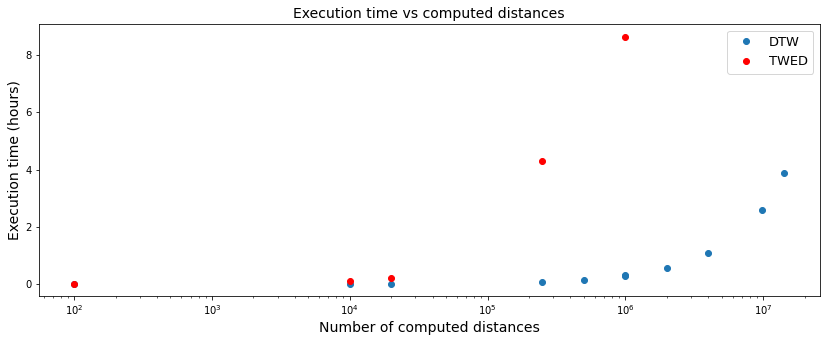

In [161]:
# execution time dtw distances
dtw_dist_time = [0.123, 6.227, 16.468, 253.757, 513.756, 1047.021, 992.615, 
                1956.488, 3896.741, 13898.950, 9336.39]
dtw_train_len = [10, 100, 200, 500, 1000, 1000, 1000, 2000, 2000, 5000,  6278]
dtw_test_len = [10, 100, 100, 500, 500, 1000, 1000, 1000, 2000, 2847, 1570]
dtw_tot = np.array(dtw_train_len) * np.array(dtw_test_len)
twed_dist_time = [2.1, 326.245, 721.75, 15460.57, 31179.298]
twed_train_len = [10,  100,     200,    500,      1000]
twed_test_len = [10, 100, 100, 500, 1000]
twed_tot = np.array(twed_train_len) * np.array(twed_test_len)

fig = plt.figure(figsize=(14, 5))
plt.semilogx(dtw_tot, np.array(dtw_dist_time) / 60 / 60, 'o', label="DTW")
plt.semilogx(twed_tot, np.array(twed_dist_time) / 60 / 60, 'ro', label="TWED")
plt.xlabel("Number of computed distances", fontsize=14)
plt.ylabel("Execution time (hours)", fontsize=14)
plt.title("Execution time vs computed distances", fontsize=14)
plt.legend(fontsize=13)

| Train set | Test set | classes | accuracy 1-NN classify DTW | accuracy 1-NN classify TWED |
| :-: | :-: | :-: | :-: | :-: |
| 10 | 10 | 2 | 0.8 | 0.4 | 
| 100 | 100 | 4 | 0.31 | 0.17 |
| 200 | 100 | 4 | 0.35 | 0.51 |
| 500 | 500 | 4 | 0.32 | 0.43 |
| 1000 | 500 | 4 | 0.35 | -- |
| 1000 | 1000 | 4 | 0.35 | -- |
| 1000 | 1000 | 10 | 0.25 | 0.32 |
| 2000 | 1000 | 14 | 0.18 | -- |
| 2000 | 2000 | 14 | 0.18 | -- |
| 5000 | 2847 | 14 | 0.18 | -- |
| 6278 | 1570 | 14 | 0.23 | -- |

| Train set | Test set | classes | mAP@k(k=10) DTW | mAP@k(k=10) TWED |
| :-: | :-: | :-: | :-: | :-: |
| 10 | 10 | 2 | 0.63 | 0.74 | 
| 100 | 100 | 4 | 0.33 | 0.27 |
| 200 | 100 | 4 | 0.33 | 0.17 |
| 500 | 500 | 4 | 0.29 | 0.30 |
| 1000 | 500 | 4 | 0.26 | -- |
| 1000 | 1000 | 4 | 0.25 | -- |
| 1000 | 1000 | 10 | 0.13 | 0.03 |
| 2000 | 1000 | 14 | 0.17 | -- |
| 2000 | 2000 | 14 | 0.16 | -- |
| 5000 | 2847 | 14 | 0.16 | -- |
| 6278 | 1570 | 14 | 0.18 | -- |

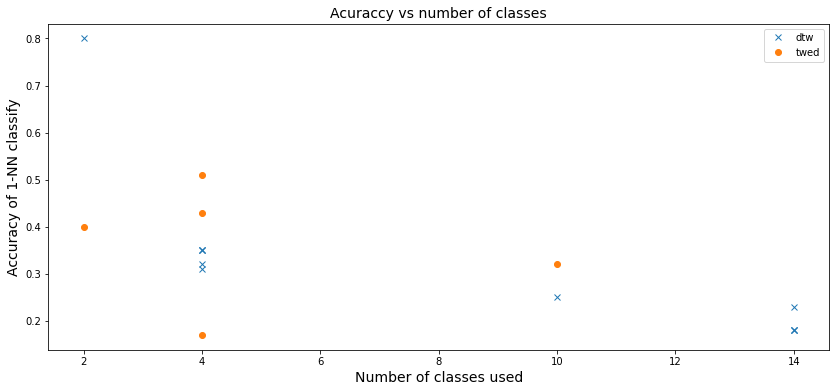

In [185]:
dtw_acc = [0.8, 0.31, 0.35, 0.32, 0.35, 0.35, 0.25, 0.18, 0.18, 0.18, 0.23]
fig = plt.figure(figsize=(14, 6))
plt.plot([2, 4, 4, 4, 4, 4, 10, 14, 14, 14, 14], dtw_acc, 'x', label="dtw")
twed_acc = [0.4, 0.17, 0.51, 0.43, 0.32]
plt.plot([2, 4, 4, 4, 10], twed_acc, 'o', label="twed")
plt.xlabel("Number of classes used", fontsize=14)
plt.ylabel("Accuracy of 1-NN classify", fontsize=14)
plt.title("Acuraccy vs number of classes", fontsize=14)
plt.legend()